# Parcellation

Goal: Compare different parcellations

## Setup

In [2]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [22]:
# Import local code
import sys
sys.path.append('../code')
from pcaVersion import *
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

In [4]:
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
dm_dx_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dx_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=hcp_ds9
New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9
New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [5]:
hcp_scores = dm_hcp_ds9.clean_scores().assign(version='HCP-MMP1.0,\ntop 10% DS genes')
dk_scores = dm_dk_ds9.clean_scores().assign(version='Desikan-Killiany,\ntop 10% DS genes')
dx_scores = dm_dx_ds9.clean_scores().assign(version='Desterieux,\ntop 10% DS genes')

In [7]:
# weights_version = dm_hcp_3d_ds5
# weights_version.fit_weights(normalize=False);
weights_version = dm_hcp_ds9
# weights_version.fit_weights()
# weights_version.fit_weights(dm_hcp_3d_ds5.expression)

In [8]:
corrs_dict = {
    'HCP-MMP1.0,\ntop 10% DS genes': correlate(dm_hcp_ds9.fit_weights(overwrite=False), weights_version.weights),
    'Desikan-Killiany,\ntop 10% DS genes': correlate(dm_dk_ds9.fit_weights(), weights_version.weights),
    'Desterieux,\ntop 10% DS genes': correlate(dm_dx_ds9.fit_weights(), weights_version.weights)
}

weight_corrs = (pd.concat(corrs_dict)
 .melt(ignore_index=False)
 .reset_index()
 .set_axis(['version','x','y','corr'], axis=1)
 .loc[lambda x: (x['x'] < 3) & (x['y'] < 3)]
 .replace({'x':{0:'G1',1:'G2',2:'G3'}, 'y':{0:'G1',1:'G2',2:'G3'}})
)

In [9]:
def count_gene_overlap(v1, v2):
    overlap = set(v1.weights.index).intersection(set(v2.weights.index))
    overlap_v1 = round(len(overlap)/len(v1.weights.index),2)*100
    overlap_v2 = round(len(overlap)/len(v2.weights.index),2)*100
    print(f'Overlap is {overlap_v1}% of v1 genes, {overlap_v2}% of v2 genes')
    
count_gene_overlap(dm_hcp_ds9, dm_dk_ds9)

Overlap is 85.0% of v1 genes, 85.0% of v2 genes


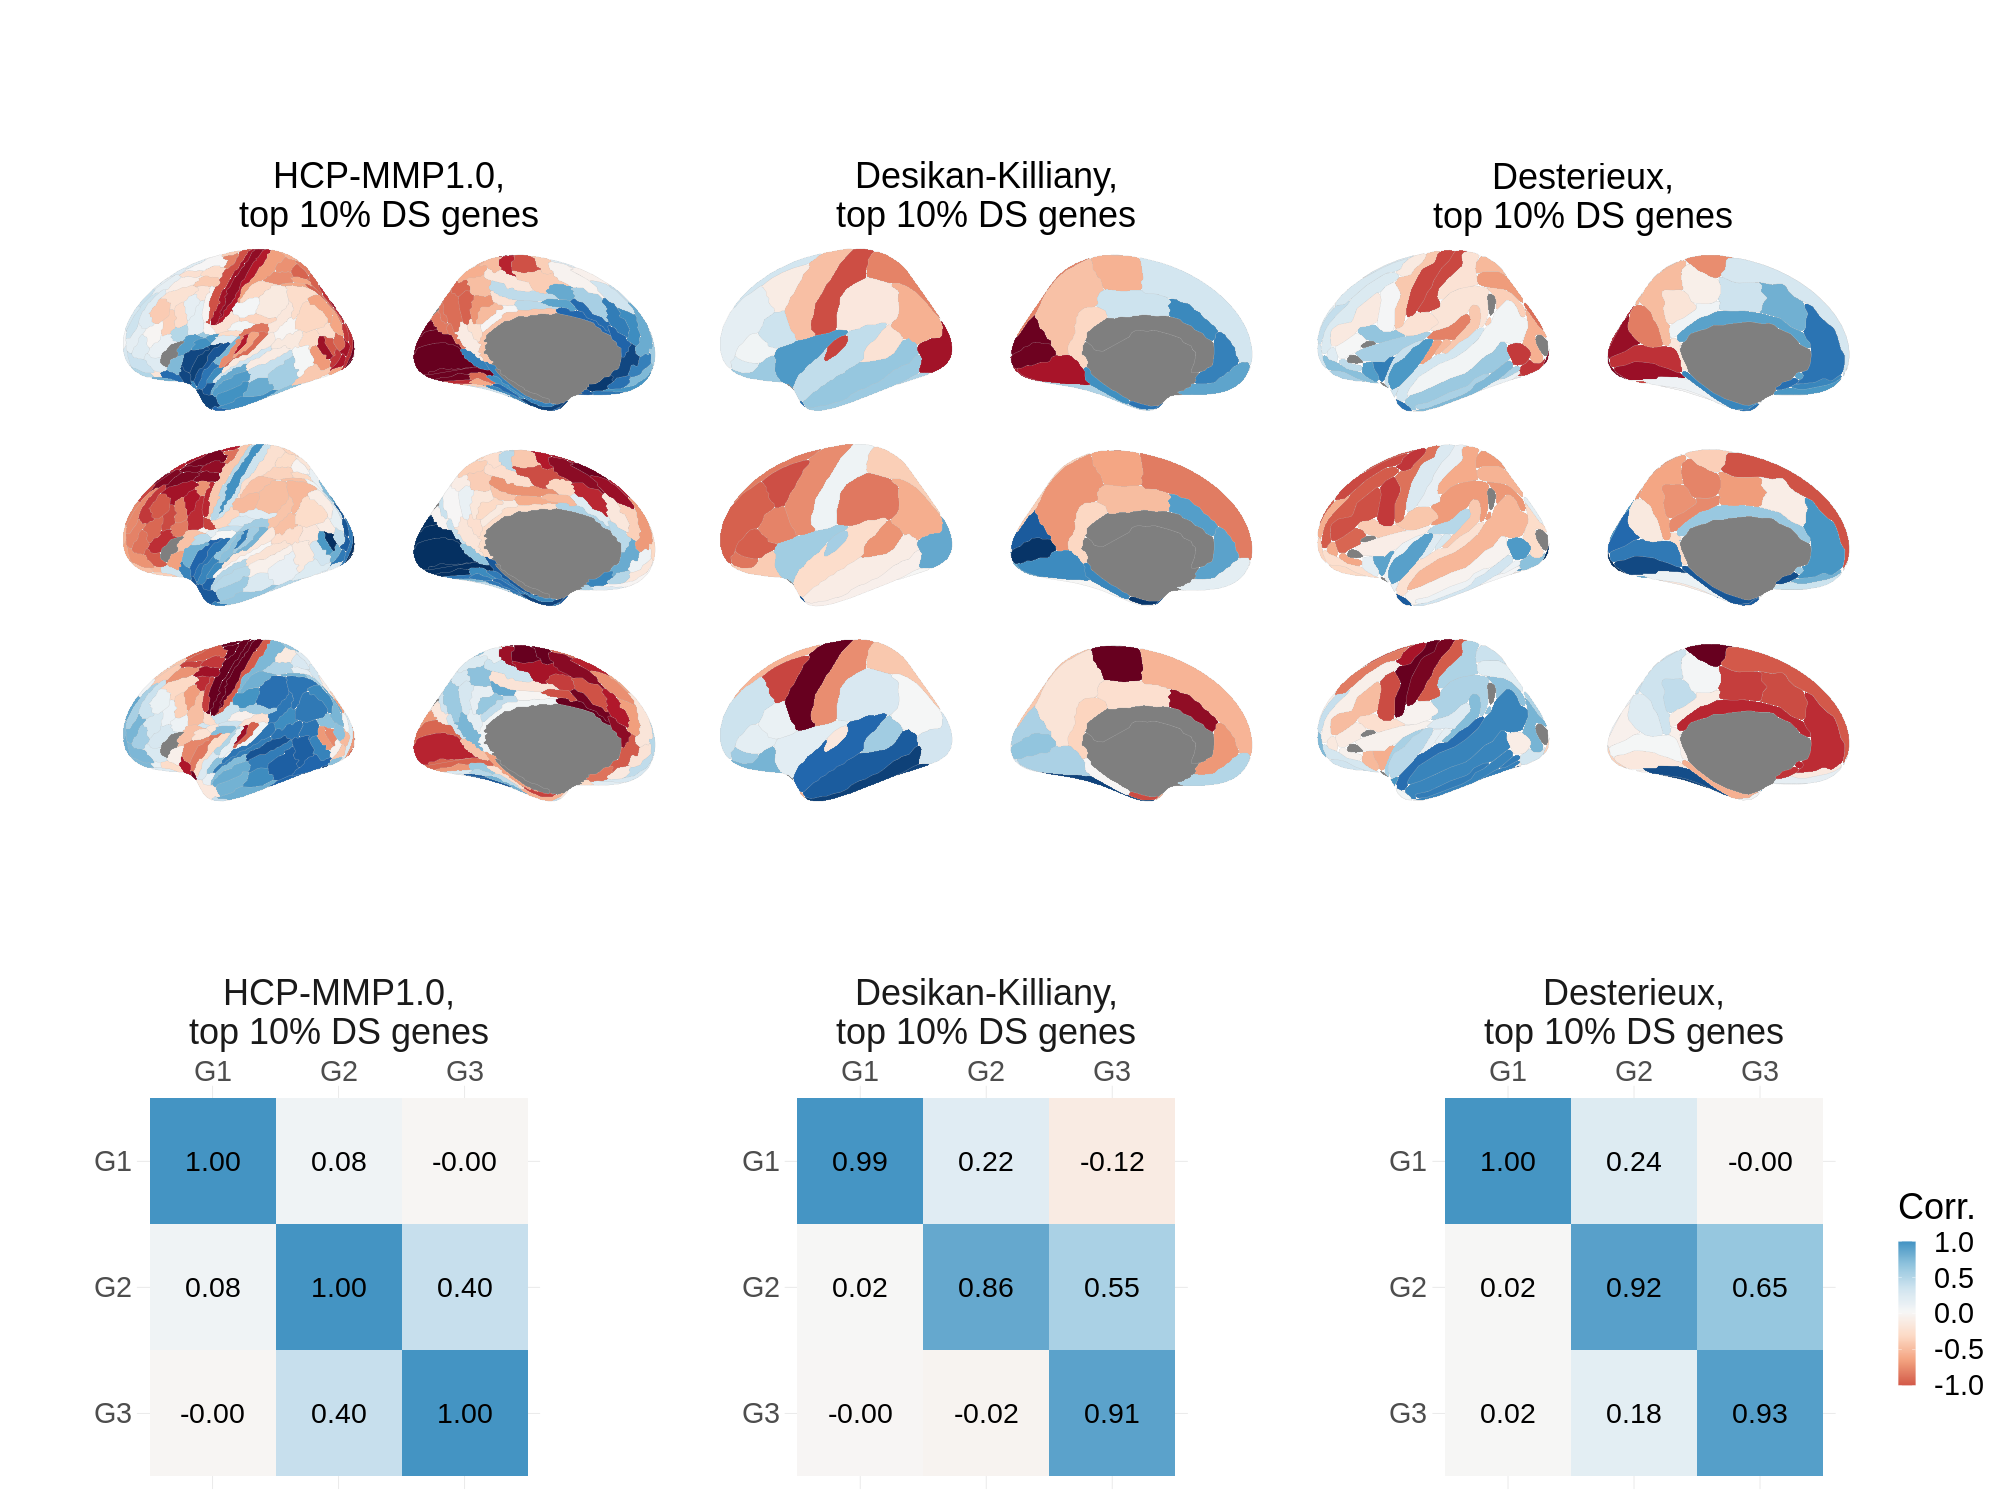

In [20]:
%%R -w 2000 -h 1500 -i hcp_scores -i dk_scores -i dx_scores -i weight_corrs 
source("../code/Rplots.R")
source("../code/brainspanPlots.R")

g1a <- plot_hcp(hcp_scores, three=T)
g1b <- plot_dk(dk_scores, three=T) + plot_layout(tag_level='new')
g1c <- plot_dx(dx_scores, three=T) + plot_layout(tag_level='new')

g2 <- plot_weight_corrs(weight_corrs) + ylab('')


plot <- (
    ((g1a | g1b | g1c) & theme(legend.position='none', strip.text.y=element_blank())) /
    g2 
) + plot_layout(heights=c(2,1))


themed <- plot & theme(
    text=element_text(size=36), 
    strip.text = element_text(size=36)
)
themed

---

Try other atlases from https://github.com/neurodata/neuroparc/tree/master/atlases/label/Human

# Schaefer 200

Not working ...

In [163]:
%%R
# Save labels
library(ggsegSchaefer)
schaefer_left <- schaefer17_200$data %>% filter(hemi=='left')
data.frame(id=schaefer_left$roi, label=schaefer_left$label) %>% mutate(id=as.numeric(id)) %>% write_csv("../data/parcellations/schaefer200_ggseg_labels.csv")

In [173]:
get_expression_abagen(fetch_s200(), DS_threshold=0.9, save_name='s200_ds9', verbose=1)

INFO: Group-level atlas provided; using MNI coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 32670 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15947 genes remain after probe filtering + selection


IndexError: Boolean index has wrong length: 2 instead of 1

In [129]:
dm_s200_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('s200_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [148]:
s200_scores = (dm_s200_ds9.scores
             .apply(lambda x: (x-np.mean(x))/np.std(x))
             .join(get_labels_s200()).assign(version='Schaefer200')
            )

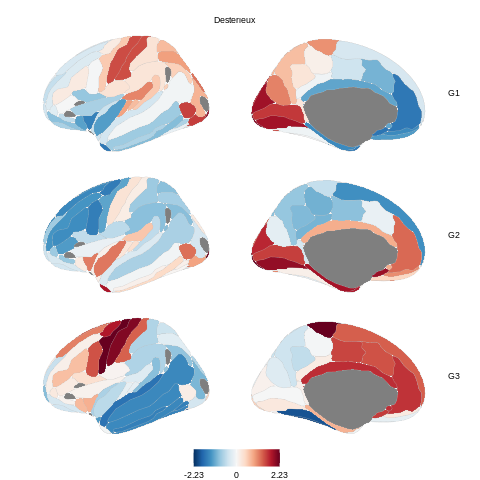

In [150]:
%%R -i s200_scores
plot_s200(s200_scores, three=T)

# Destrieux atlas

In [128]:
get_expression_abagen(fetch_dx(), DS_threshold=0.9, save_name='dx_ds9')

1595 genes remain after filtering for top 0.1 differential stability


gene_symbol,A1BG,ABCA6,ABCC8,ABCG4,ABCG5,ABHD12B,ABLIM2,ABLIM3,ABTB2,ACAN,...,ZNF385A,ZNF385B,ZNF502,ZNF677,ZNF706,ZNF831,ZNRF1,ZSCAN18,ZSCAN29,ZYX
label,,,,,,,,,,,,,,,,,,,,,
1,0.669975,0.436774,0.619475,0.312360,0.742532,0.609773,0.639669,0.566026,0.281841,0.277145,...,0.513845,0.738389,0.386511,0.603658,0.510986,0.466365,0.714901,0.543708,0.720747,0.418160
2,0.399734,0.739016,0.745086,0.602295,0.244029,0.299685,0.263124,0.250558,0.626828,0.712763,...,0.689124,0.765634,0.663173,0.552850,0.253188,0.257184,0.301789,0.339279,0.699759,0.730661
3,0.300167,0.584695,0.525424,0.766994,0.538096,0.671267,0.149648,0.430823,0.691805,0.834167,...,0.734431,0.391939,0.418943,0.264530,0.274357,0.337885,0.246307,0.274375,0.393944,0.653194
4,0.523203,0.555421,0.563779,0.438520,0.638232,0.593747,0.332243,0.510567,0.617516,0.566710,...,0.500797,0.490600,0.487531,0.456691,0.429272,0.554466,0.387287,0.474651,0.573820,0.548913
5,0.466865,0.417122,0.498223,0.470159,0.755218,0.590638,0.498723,0.678982,0.368044,0.373056,...,0.541827,0.452625,0.515072,0.647952,0.613463,0.581820,0.592606,0.642334,0.707927,0.449921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.637139,0.231776,0.605328,0.549727,0.687728,0.771858,0.717816,0.885048,0.254828,0.120908,...,0.319638,0.337406,0.553942,0.576493,0.814511,0.888048,0.702357,0.869616,0.397432,0.314954
72,0.513538,0.500677,0.610342,0.633921,0.409916,0.593891,0.403883,0.479176,0.468258,0.463867,...,0.556050,0.530638,0.472556,0.534838,0.461770,0.417895,0.363360,0.454273,0.558256,0.599547
73,0.702828,0.410978,0.576326,0.274208,0.186300,0.442997,0.630004,0.482067,0.391808,0.220260,...,0.438801,0.588407,0.529138,0.692968,0.501420,0.701941,0.725222,0.593443,0.693127,0.491121


In [129]:
dm_dx_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dx_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [148]:
dx_scores = (dm_dx_ds9.scores
             .apply(lambda x: (x-np.mean(x))/np.std(x))
             .join(get_labels_dx()).assign(version='Desterieux')
            )

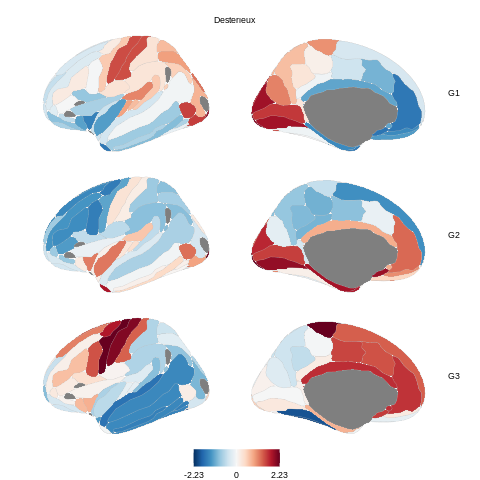

In [150]:
%%R -i dx_scores
plot_dx(dx_scores, three=T)

---

In [4]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))

New PCA version
New PCA version


In [19]:
dk_expression, stability = get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0, save_name='dk_native_base', return_stability=True)

In [21]:
stability.to_csv("../outputs/stability_dk.csv")

In [24]:
dk_base = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0, save_name='dk_base'))
dk_ds5 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.5, save_name='dk_ds5'))
dk_3donors_ds5 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=3, DS_threshold=0.5, save_name='dk_3donors_ds5'))
dk_3donors_ds8 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=3, DS_threshold=0.8, save_name='dk_3donors_ds8'))

New PCA version
7973 genes remain after filtering for top 0.5 differential stability
New PCA version
7973 genes remain after filtering for top 0.5 differential stability
New PCA version
3190 genes remain after filtering for top 0.2 differential stability
New PCA version


In [12]:
dk_ds4 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.4, save_name='dk_ds4'))
dk_ds3 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.3, save_name='dk_ds3'))
dk_ds2 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.2, save_name='dk_ds2'))

9568 genes remain after filtering for top 0.6 differential stability
New PCA version
11162 genes remain after filtering for top 0.7 differential stability
New PCA version
12757 genes remain after filtering for top 0.8 differential stability
New PCA version


In [5]:
dk_base = pcaVersion(pd.read_csv(data_dir + 'dk_base.csv', index_col=0))
dk_ds5 = pcaVersion(pd.read_csv(data_dir + 'dk_ds5.csv', index_col=0))
dk_3donors_ds5 = pcaVersion(pd.read_csv(data_dir + 'dk_3donors_ds5.csv', index_col=0))
dk_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'dk_3donors_ds8.csv', index_col=0))

New PCA version
New PCA version
New PCA version
New PCA version


In [16]:
corrs_dict = {
    'DK 3-donors DS 0.8': hcp_3donors_ds8.corr_coefs(dk_3donors_ds8),
    'DK 3-donors DS 0.5': hcp_3donors_ds8.corr_coefs(dk_3donors_ds5),
    'DK DS 0.5': hcp_3donors_ds8.corr_coefs(dk_ds5),
    'DK DS 0.4': hcp_3donors_ds8.corr_coefs(dk_ds4),
    'DK DS 0.3': hcp_3donors_ds8.corr_coefs(dk_ds3),
    'DK DS 0.2': hcp_3donors_ds8.corr_coefs(dk_ds2),
    # 'HCP 3d 0.8 vs DK base': hcp_3donors_ds8.corr_coefs(dk_base),
}
df_corrs = (pd.concat(corrs_dict)
            .stack().reset_index()
            .set_axis(['version','x','y','corr'],axis=1)
           )

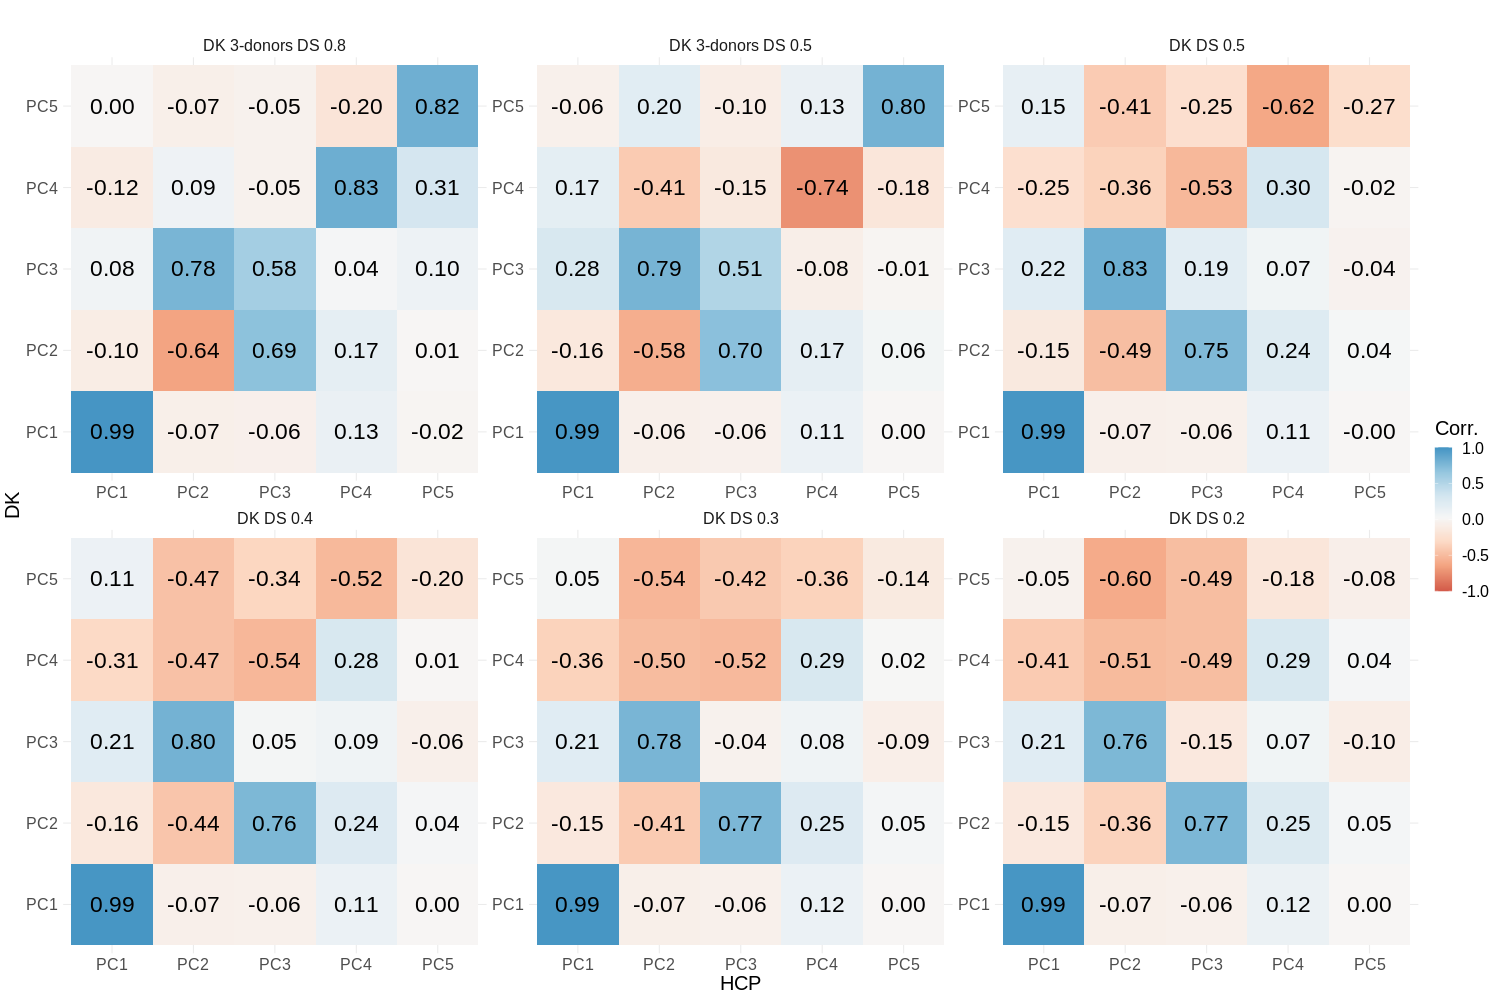

In [17]:
%%R -w 1500 -h 1000 -i df_corrs
plot_corrs(df_corrs, facetting='w') & theme(text=element_text(size=20))

In [9]:
corrs_dict = {
    'Base': hcp_native_base.corr_coefs(dk_native_base),
    '3D DS5': hcp_native_3donors_ds5.corr_coefs(dk_native_3donors_ds5),
    '3D DS8': hcp_native_3donors_ds8.corr_coefs(dk_native_3donors_ds8),
}
df_corrs = (pd.concat(corrs_dict)
            .stack().reset_index()
            .set_axis(['version','x','y','corr'],axis=1)
           )

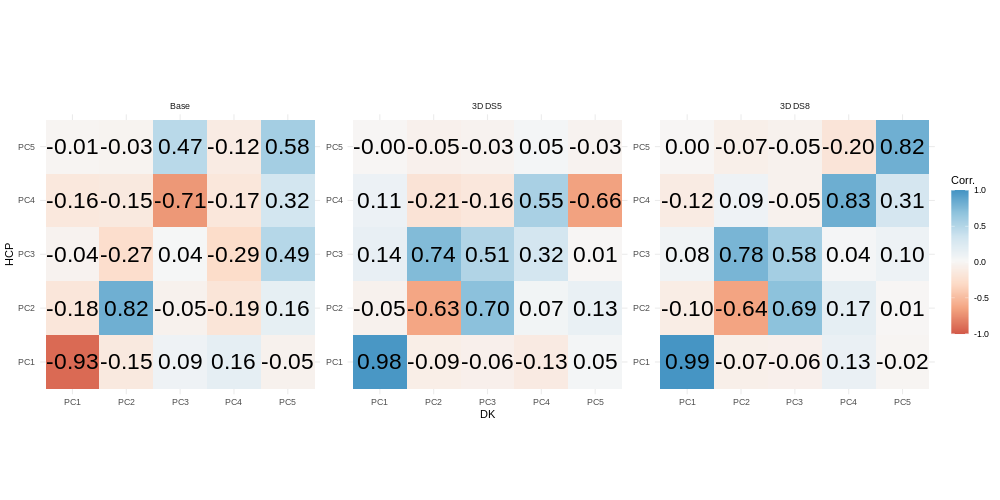

In [10]:
%%R -w 1000 -h 500 -i df_corrs
plot_corrs(df_corrs)